# EIT Continuous Model Complex-Valued Tests

This work aims to set first tests with EIT implementantion using FENICSx library, aiming to solve the complex valued case, explaining some of the fundamentals in the library implementation. In this context, we will be using the Continuous Model, testing initially with trivial simulated functions and simple meshes, adding more information and complexity as advancing.

More information and explanations about some steps can be seen in the FENICSx tutorial: https://jsdokken.com/dolfinx-tutorial/chapter1/complex_mode.html.

# Implementation - Direct Problem



## Importing

Run the following blocks to install and import all the libraries required.

In [248]:
try:
    import gmsh
except ImportError:
    !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/75de0a3/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
    import gmsh

try:
    import dolfinx
except ImportError:
  !wget "https://github.com/fem-on-colab/fem-on-colab.github.io/raw/75de0a3/releases/fenicsx-install-complex.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
  import dolfinx

try:
    import pyvista
except ImportError:
    !wget "https://fem-on-colab.github.io/releases/vtk-install.sh" -O "/tmp/vtk-install.sh" && bash "/tmp/vtk-install.sh"
    import pyvista

pyvista.set_jupyter_backend("static")

import sys
import dolfinx
from mpi4py import MPI #import parallel communicator
import numpy as np
import ufl
import matplotlib.pyplot as plt
import dolfinx.fem.petsc
from dolfinx.io import gmshio
import time
import pandas as pd

print("Python version: ", sys.version)
print(f"DOLFINx version: {dolfinx.__version__} based on GIT commit: {dolfinx.git_commit_hash} of https://github.com/FEniCS/dolfinx/")


#Check type of number set in PETSc lib, returns error if not complex
from petsc4py import PETSc #Linear algebra lib
print(PETSc.ScalarType)
assert np.dtype(PETSc.ScalarType).kind == 'c'

Python version:  3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
DOLFINx version: 0.8.0.0 based on GIT commit: 230e027269c0b872c6649f053e734ed7f49b6962 of https://github.com/FEniCS/dolfinx/
<class 'numpy.complex128'>


# Setting mesh

## Finding Eletrodes

In [233]:
# trecho do código do Eduardo
class electrodes_position():
    """
    Object that contains the position of the electrodes in the boundary.
    The position is stored as the initial and final angles of each electrode.

    :param L: Number of electrodes.
    :type L: int
    :param per_cober: Percentual covered length in the boundary by electrodes, between 0 and 1.
    :type per_cober: float
    :param rotate: Rotation angle in the original solution for electrodes (in radians).
    :type rotate: float
    :param anticlockwise: If True, the electrodes are positioned anticlockwise, else clockwise.
    :type anticlockwise: bool, optional (default is True)

    :Example:
        >>> ele_pos = electrodes_position(L=16, per_cober=0.5, rotate=0)
        >>> print(ele_pos.position)
        [[0.0, 0.19634954084936207],
         [0.39269908169872414, 0.5890486225480862],
         [0.7853981633974483, 0.9817477042468103],
         [1.1780972450961724, 1.3744467859455345],
         [1.5707963267948966, 1.7671458676442586],
         ...,
         [5.890486225480862, 6.086835766330224]]
    """

    def __init__(self, L, per_cober, rotate, anticlockwise=True):
        #Checks
        if not isinstance(L, int): raise ValueError("Number of electrodes must be an integer.")
        if not isinstance(per_cober, float): raise ValueError("per_cober must be a float.")
        if not isinstance(rotate, (int, float)): raise ValueError("rotate must be a float.")
        if not isinstance(anticlockwise, bool): raise ValueError("anticlockwise must be true of false.")
        if per_cober>1: raise ValueError("per_cober must be equal or less than 1. Example (75%): per_cober=0.75 ")

        self.rotate=rotate
        self.L=L
        self.per_cober=per_cober
        self.anticlockwise=anticlockwise

        self.position=self.calc_position()


    def calc_position(self):
        """
        Calculate the position of electrodes based on the :class:`electrodes_position` object.

        :returns: list of arrays -- Returns a list with angle initial and final of each electrode.
        """
        size_e=2*np.pi/self.L*self.per_cober       #Size electrodes
        size_gap=2*np.pi/self.L*(1-self.per_cober) #Size gaps
        rotate=self.rotate                      #Rotating original solution

        electrodes=[]
        for i in range(self.L):
            #Example electrodes=[[0, pi/4], [pi/2, pi]]
            electrodes.append([size_e*i+size_gap*i+rotate, size_e*(i+1)+size_gap*i+rotate]) #Grouping angular values for electrodes.
        if not self.anticlockwise:
            electrodes[1:] = electrodes[1:][::-1] #Keep first electrode and reverse order
        return electrodes
L=16
perc=0.5

electrodes = electrodes_position(L,perc,0)
print(electrodes.position)

[[0.0, 0.19634954084936207], [0.39269908169872414, 0.5890486225480862], [0.7853981633974483, 0.9817477042468103], [1.1780972450961724, 1.3744467859455345], [1.5707963267948966, 1.7671458676442586], [1.9634954084936207, 2.1598449493429825], [2.356194490192345, 2.552544031041707], [2.748893571891069, 2.945243112740431], [3.141592653589793, 3.3379421944391554], [3.5342917352885173, 3.730641276137879], [3.9269908169872414, 4.123340357836604], [4.319689898685965, 4.516039439535327], [4.71238898038469, 4.908738521234052], [5.105088062083414, 5.301437602932776], [5.497787143782138, 5.6941366846315], [5.890486225480862, 6.086835766330224]]


In [234]:
#vetor com as coordenadas iniciais e finais de cada eletrodo
elec_coordinates = [((np.cos(electrode[0]),np.sin(electrode[0])), (np.cos(electrode[1]),np.sin(electrode[1]))) for electrode in electrodes.position]

In [235]:
mesh_refining = 0.5 #scaling factor for all bdr refinement
bdr_refining = 0.8 # scaling factor for border refining

# if running again, you must remove the comment in the following
gmsh.finalize()
gmsh.initialize()
disk = gmsh.model.occ.addDisk(0, 0, 0, 1, 1) #creates disk centered in (0,0,0) with axis (1,1)

#create point list for electrodes.
#primeiro, do jeito gambiarrento -
electrodes_points = []
for electrode in electrodes.position:
  theta_array = np.linspace(electrode[0],electrode[1],)
  electrodes_points.extend([gmsh.model.occ.addPoint(np.cos(theta),np.sin(theta),0) for theta in theta_array])

gmsh.model.occ.synchronize()
gdim = 2 #variable to control disk dimension, where 2 stands for surface
gmsh.model.addPhysicalGroup(gdim, [disk], 1) # starts mesh object
# gmsh.model.addPhysicalGroup(0, electrodes_points, 2) #electrodes


gmsh.option.setNumber("Mesh.CharacteristicLengthMax",0.2 * mesh_refining) # control max length of cells
gmsh.model.mesh.field.add("Distance", 1)
gmsh.model.mesh.field.setNumbers(1, "PointsList", electrodes_points)
gmsh.model.mesh.field.add("Threshold", 2)
gmsh.model.mesh.field.setNumber(2, "InField", 1)
gmsh.model.mesh.field.setNumber(2, "SizeMin", 0.03 * bdr_refining)
gmsh.model.mesh.field.setNumber(2, "SizeMax", 0.25 * bdr_refining )
gmsh.model.mesh.field.setNumber(2, "DistMin", 0.075 * bdr_refining )
gmsh.model.mesh.field.setNumber(2, "DistMax", 0.1 * bdr_refining)
gmsh.model.mesh.field.add("Min", 3)
gmsh.model.mesh.field.setNumbers(3, "FieldsList", [2])
gmsh.model.mesh.field.setAsBackgroundMesh(3)
gmsh.option.setNumber("Mesh.MeshSizeExtendFromBoundary", 0)
gmsh.option.setNumber("Mesh.MeshSizeFromPoints", 0)
gmsh.option.setNumber("Mesh.MeshSizeFromCurvature", 0)
gmsh.model.mesh.generate(gdim)

#start graphic server
pyvista.start_xvfb()
gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD

#convert gmsh created mesh to dolfin/fenics mesh objects
mesh, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)
topology, cell_types, x = dolfinx.plot.vtk_mesh(mesh) #convert dolfin mesh to vtk (plotting lib) manageable object

## Plotting domain

static


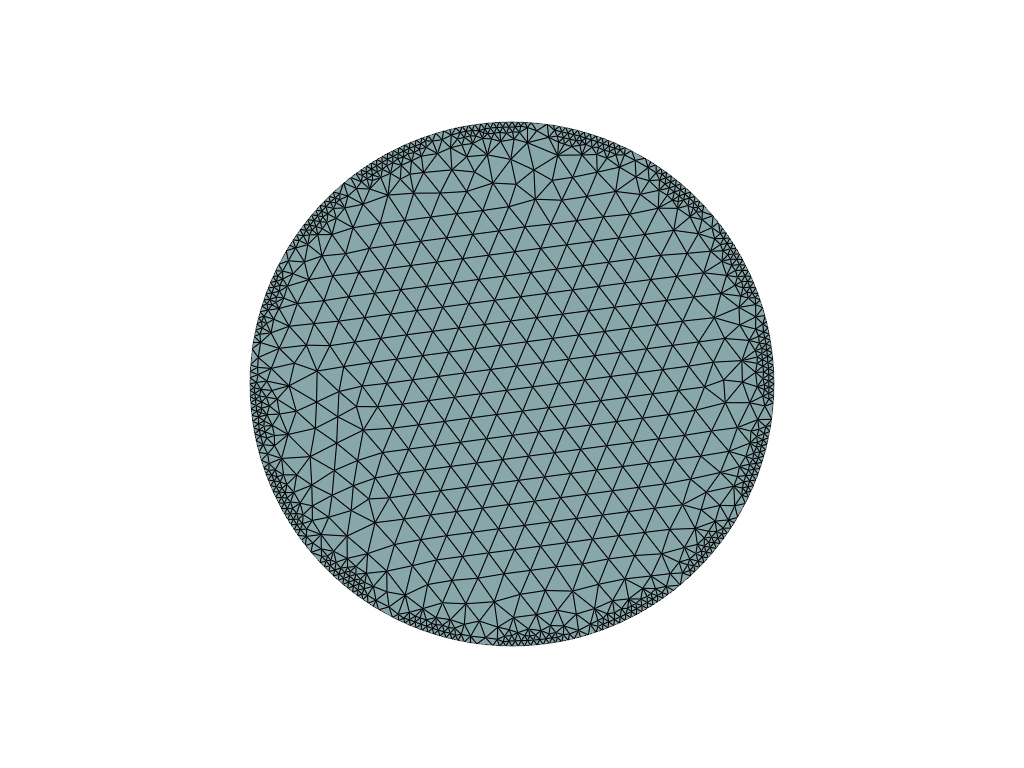

In [236]:
#set value (plotting zero function in mesh)
num_cells_local = mesh.topology.index_map(mesh.topology.dim).size_local #get vertex array size
marker = np.zeros(num_cells_local, dtype=np.int32) #zero-full array, represents value in each vertex

# plotter object settings
# option "static" for static plots. Interactive options were not working properly in colab
pyvista.set_jupyter_backend("static")
print(pyvista.global_theme.jupyter_backend)

# Ploting mesh
p = pyvista.Plotter(notebook=True)
grid = pyvista.UnstructuredGrid(topology, cell_types, x)
p.add_mesh(grid, show_edges=True)
p.view_xy()
if pyvista.OFF_SCREEN:
    figure = p.screenshot("disk.png")
p.show()

## Getting integration domains

Based on the method explored in:
https://jsdokken.com/dolfinx-tutorial/chapter3/robin_neumann_dirichlet.html

Basic idea:
- Create a indicator function for each domain, the electrodes in our case;
- Uses fenicsx `dolfinx.mesh.locate_entities(mesh, fdim, locator)` for listing the tags which lies in the electrodes;
- Creates a custom `ds` integration object, informing the electrodes tags. Then, it is possible to compute the integration in the $i-th$ domain by the command `f * ds(i)`.

In our code, the electrodes are located by their starting and ending angles, here stored in `electrodes.position` array. Then, we use the indicator function $f_k$ for the $k-th$ electrode. Beeing $\theta$ the boundary point angle, and given $\theta^{(k)}_i,\theta^{(k)}_f$ the starting and ending electrode angles respectively, $f_k(\theta)$ may be get by:
$$
f_k(\theta) = \begin{cases}
1, \text{if } \theta_i^{(k)} \leq \theta \leq \theta_f^{(k)} \\
0, else.
\end{cases}
$$

Here, as fenicsx inform an array of cartesian coordinates, we may get the corresponding $\theta$ by the function?
$$
\theta(x,y) = \begin{cases}
  \arccos(x), \text{ if } y\geq 0\\
  2\pi - \arccos(x), \text{ else}.
\end{cases}
$$
given $(x,y) = (r\cos(\theta),r\sin(\theta))$ with $\theta \in [0,2\pi )$.

In [237]:

# gets theta of (x,y) in polar coord. (r,theta), with theta in interval [0,2pi]
def theta(x):
  r = (x[0]**2 + x[1]**2)**(0.5)
  inv_r = np.where(np.isclose(r,0),0,1/r)
  return np.where(x[1]>=0,np.arccos(x[0]*inv_r),2*np.pi - np.arccos(x[0]*inv_r))
  # return np.where(x[1]>=0,np.arccos(x[0]),2*np.pi - np.arccos(x[0]))


# Here is a tolerance for the test theta_i-tol <= theta <= theta_f
# this shown some better results on the integrations
tol = 0.01 # tolerance for checking if in electordes

#setting boundaries markers and indicator functions
boundaries = [
    (i, lambda x,i=i: np.where(np.logical_and(theta(x)>=electrodes.position[i][0]-tol,theta(x)<=electrodes.position[i][1]+tol),1,0))
    # (i, lambda x,i=i: np.where(theta(x)>=electrodes.position[i][0],1,0))
    for i in range(L)
]

#creating facet tags
facet_indices, facet_markers = [], []
fdim = mesh.topology.dim - 1
for (marker, locator) in boundaries:
    facets = dolfinx.mesh.locate_entities(mesh, fdim, locator)
    facet_indices.append(facets)
    facet_markers.append(np.full_like(facets, marker))
facet_indices = np.hstack(facet_indices).astype(np.int32)
facet_markers = np.hstack(facet_markers).astype(np.int32)
sorted_facets = np.argsort(facet_indices)
facet_tag = dolfinx.mesh.meshtags(mesh, fdim, facet_indices[sorted_facets], facet_markers[sorted_facets])

In [238]:
# Create the `ds` object for integration domains
ds = ufl.Measure("ds", domain=mesh, subdomain_data=facet_tag)

### Testing domains

Testing integral over electrodes. Here, we compute
$$
\int_{e_i} 1 ds
$$
for each $e_i \subset \partial \Omega$ electrode, through the fenicsx functions
```
v = ufl.TrialFunction(V0)
s = v*ds(i)
```

Given the circular domain, with all electrodes having same side and covering a $0<p<1$ fraction of the boundary, we expect that

$$
\int_{e_i} 1 ds = \frac{2 \pi}{L}*p
$$

In [240]:
#Computing "true" area
electrode_real_area = 2*np.pi/L * perc
print("Electrode area: ",electrode_real_area)

Electrode area:  0.19634954084936207


In [251]:
V0 = dolfinx.fem.FunctionSpace(mesh, ("DG", 0)) #Function space object

cell_area_list = []
for i in range(L):
  v = ufl.TrialFunction(V0) #trial object
  s = v*ds(i) # creates object of the form \int_{e_i} 1*ds

  cell_area_form = dolfinx.fem.form(s)
  cell_area = dolfinx.fem.assemble_scalar(cell_area_form)
  cell_area_list.append(cell_area.real)
  print("Electrode ", i ,": ", cell_area)

print("Sum:", sum(cell_area_list))

Electrode  0 :  (0.19170726283534886+0j)
Electrode  1 :  (0.19170726283534886+0j)
Electrode  2 :  (0.19170726283534897+0j)
Electrode  3 :  (0.1917072628353492+0j)
Electrode  4 :  (0.1917072628353487+0j)
Electrode  5 :  (0.1917072628353492+0j)
Electrode  6 :  (0.19170726283534917+0j)
Electrode  7 :  (0.19170726283534917+0j)
Electrode  8 :  (0.1917072628353483+0j)
Electrode  9 :  (0.1917072628353474+0j)
Electrode  10 :  (0.19170726283534878+0j)
Electrode  11 :  (0.1917072628353478+0j)
Electrode  12 :  (0.19170726283534875+0j)
Electrode  13 :  (0.19170726283534695+0j)
Electrode  14 :  (0.1917072628353469+0j)
Electrode  15 :  (0.1917072628353479+0j)
Sum: 3.0673162053655743


In [253]:
cell_area_array = np.array(cell_area_list)
error_array = cell_area_array-electrode_real_area
print("Electrode length:", electrode_real_area)
electrode_area_df = pd.DataFrame({"Calculated area": cell_area_array,"Error": error_array})
electrode_area_df.head(n=L)

Electrode length: 0.19634954084936207


,Calculated area,Error
0,0.191707,-0.004642
1,0.191707,-0.004642
2,0.191707,-0.004642
3,0.191707,-0.004642
4,0.191707,-0.004642
5,0.191707,-0.004642
6,0.191707,-0.004642
7,0.191707,-0.004642
8,0.191707,-0.004642
9,0.191707,-0.004642


Here, ploting the indicator function in all domain. Note that we get not only on boundary, but interior, for where we get this "radial" plot.

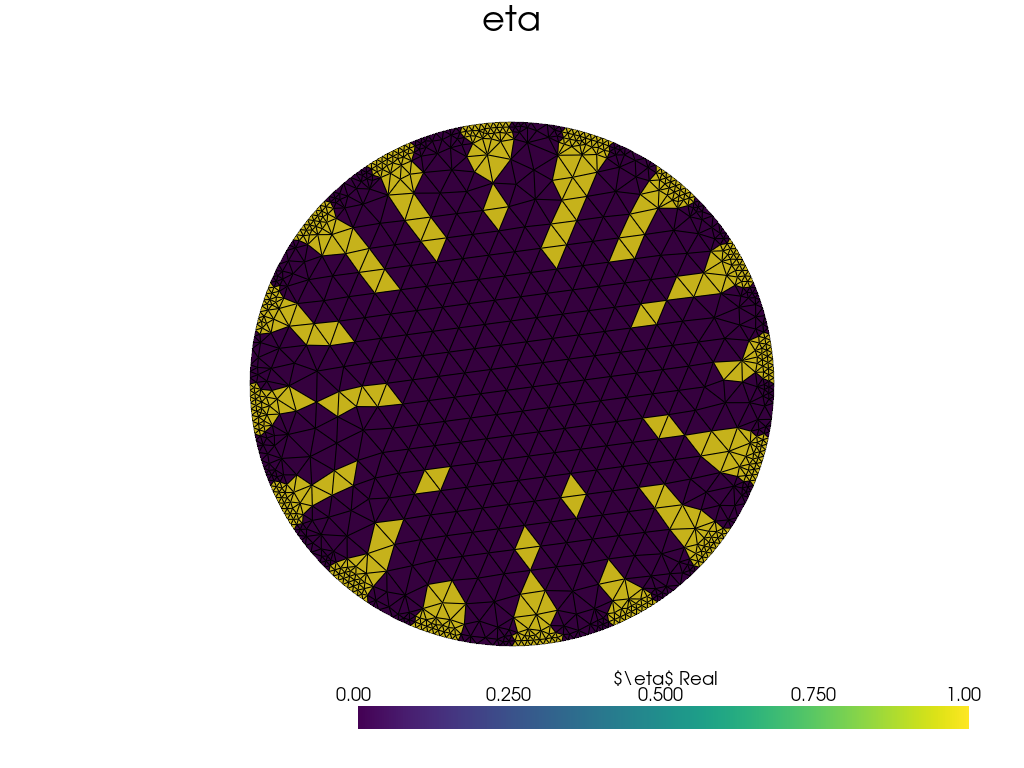

In [254]:
V0 = dolfinx.fem.FunctionSpace(mesh, ("DG", 0)) #space of piecewise constant functions in omega

eta = dolfinx.fem.Function(V0, dtype=np.complex128) #create a null function in the space

for i in range(L):
  eta_cells = dolfinx.mesh.locate_entities(mesh,2,boundaries[i][1]) #cells that respect the indicator
  eta.x.array[eta_cells] = 1  #define the vertex with set index as 1, rest remain as 0

#Plotting eta
p_mesh = pyvista.UnstructuredGrid(*dolfinx.plot.vtk_mesh(mesh,mesh.topology.dim))
pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(mesh)

grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)

grid.cell_data["$\eta$ Real"] = eta.x.array.real
grid.cell_data["$\eta$ Imaginary"] = eta.x.array.imag

grid.set_active_scalars("$\eta$ Real")
p_real = pyvista.Plotter(notebook=True)
p_real.add_text("eta", position="upper_edge", font_size=14, color="black")
p_real.add_mesh(grid,show_edges=True)
p_real.view_xy()
# p_real.set_background("white")
if not pyvista.OFF_SCREEN:
    p_real.show(jupyter_backend="static")



In [ ]:
electrodes.position[0][0]

# Extra tests

# Theta paramether location

In [255]:
t = np.linspace(0,2*np.pi,40)
x = np.array([np.cos(t),np.sin(t)])
np.where(theta(x)>=electrodes.position[14][0],1,0)
boundaries =[
    (i, lambda x,i=i: np.where(theta(x)>=electrodes.position[i][0],1,0))
    for i in range(L)
]
boundaries[1][1](x)

array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])